In [49]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy
import os
import pandas

from matplotlib import pyplot
from scipy.signal import windows

PATH = "../../results"

def sliding_window(x, kernel_size):
    """
    Computes a sliding window average over the specified data
    
    :param x: A `numpy.ndarray` of the data
    :param kernel_size: An `int` of the size of the sliding window
    
    :returns : A `numpy.ndarray` of the averaged data
    """
    if kernel_size < 2:
        return x
    window = windows.boxcar(kernel_size)
    window = window / window.sum()
    _x = numpy.pad(x, (kernel_size, kernel_size), mode="edge")
    return numpy.convolve(_x, window, mode="same")[kernel_size : -kernel_size]

def plot_score(df, x, y, shade_keys=None, smooth=1):
    """
    Plots the scores from a `pandas.DataFrame` using the provided 
    key
    
    :param df: A `pandas.DataFrame`
    :param key: A `str` of the desired key
    :param shade_keys: A `list` of keys to use as shade
    :param xlabel:
    
    :returns : A `matplotlib.Figure` of the created plot
               A `matplotlib.Axes` of the create plot
    """
    fig, ax = pyplot.subplots(figsize=(3,3))
    ax.plot(df[x], sliding_window(df[y], smooth))
    if isinstance(shade_keys, (tuple, list)):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys[0]], smooth), 
            sliding_window(df[y] + df[shade_keys[1]], smooth), 
            alpha=0.3
        )
    elif isinstance(shade_keys, str):
        ax.fill_between(
            df[x], 
            sliding_window(df[y] - df[shade_keys], smooth), 
            sliding_window(df[y] + df[shade_keys], smooth), 
            alpha=0.3
        )
    ax.set(
        xlabel=x, ylabel=y
    )
    return fig, ax

In [78]:
os.makedirs("./panels", exist_ok=True)
model_name = "test.20210706T061320.283760.backup"
# model_name = "debug"

df = pandas.read_csv(os.path.join(PATH, model_name, "scores.txt"), sep="\t")
display(df.head())

smoothing_factor = 11
fig, ax = plot_score(df, "steps", "mean", shade_keys="stdev", smooth=smoothing_factor)
# fig.savefig("./panels/mean_reward.pdf", transparent=True, bbox_inches="tight")
fig, ax = plot_score(df, "steps", "average_value", smooth=smoothing_factor)
pyplot.show()

FileNotFoundError: [Errno 2] No such file or directory: '../results/test.20210706T061320.283760.backup/scores.txt'

# Run model

In [87]:
import gym
import json
import os
import gym_sted
import pfrl
import torch
import sys
import pandas

from matplotlib import pyplot
from collections import defaultdict

while "../.." in sys.path:
    sys.path.remove("../..")
sys.path.insert(0, "../..")
from src import models, WrapPyTorch

PATH = "../../data"
model_name = "20210716-082404"

args = json.load(open(os.path.join(PATH, model_name, "args.txt"), "r"))
print(args)
def make_env(test):
    # Use different random seeds for train and test envs
    env_seed = 42
    env = gym.make(args["env"])
    # Use different random seeds for train and test envs
    env.seed(env_seed)
    # Converts the openAI Gym to PyTorch tensor shape
    env = WrapPyTorch(env)
    # Cast observations to float32 because our model uses float32
    env = pfrl.wrappers.CastObservationToFloat32(env)
    # Normalize the action space
    env = pfrl.wrappers.NormalizeActionSpace(env)
    return env

env = make_env(True)
timestep_limit = env.spec.max_episode_steps
obs_space = env.observation_space
action_space = env.action_space

obs_size = obs_space.shape
policy = models.Policy(obs_size=obs_size)
vf = models.ValueFunction(obs_size=obs_size)
model = pfrl.nn.Branched(policy, vf)

opt = torch.optim.Adam(model.parameters(), lr=args["lr"])

agent = pfrl.agents.PPO(
    model,
    opt,
    gpu=None,
    minibatch_size=args["batchsize"],
    max_grad_norm=1.0,
    update_interval=100
)
agent.load(os.path.join(PATH, model_name, "best"))


{'env': 'gym_sted:STEDbounded-v0', 'num_envs': 10, 'seed': 0, 'gpu': 0, 'outdir': './data', 'exp_id': '20210716-082404', 'batchsize': 16, 'steps': 100000, 'eval_interval': 1000.0, 'eval_n_runs': 100, 'reward_scale_factor': 1.0, 'render': False, 'lr': 0.0001, 'demo': False, 'load': '', 'log_level': 20, 'monitor': False}


NameError: name 'ORIGINAL_ACTION_SPACE' is not defined

,steps,episodes,elapsed,mean,median,stdev,max,min,average_value,average_entropy,average_value_loss,average_policy_loss,n_updates,explained_variance
0,1000,1000,1125.541610,0.26,0.0,0.440844,1.0,0.0,0.205618,1.391478,0.163780,-0.001565,630,-0.000516
1,2000,2000,2247.569596,0.22,0.0,0.416333,1.0,0.0,0.218464,1.334036,0.201385,-0.002449,1260,-0.000677
2,3000,3000,3373.035019,0.28,0.0,0.451261,1.0,0.0,0.221827,1.275160,0.180667,-0.004474,1890,-0.001669
3,4000,4000,4499.136012,0.24,0.0,0.429235,1.0,0.0,0.249882,1.214117,0.179034,-0.009111,2520,0.000977
4,5000,5000,5624.684902,0.23,0.0,0.422953,1.0,0.0,0.247302,1.155973,0.173967,-0.008366,3150,-0.001371


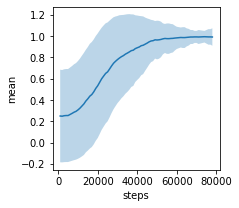

In [81]:
df = pandas.read_csv(os.path.join(PATH, model_name, "scores.txt"), sep="\t")
display(df.head())

smoothing_factor = 11
fig, ax = plot_score(df, "steps", "mean", shade_keys="stdev", smooth=smoothing_factor)
# fig.savefig("./panels/mean_reward.pdf", transparent=True, bbox_inches="tight")
# fig, ax = plot_score(df, "steps", "average_value", smooth=smoothing_factor)
pyplot.show()

In [71]:
episode_count = 10
render, done = False, False

episode_stats = []
with agent.eval_mode():
    for i in range(episode_count):
        observation = env.reset()
        timestep, cum_rewards = 0, 0
        
        stats = defaultdict(list)        
        while True:
            action = agent.act(observation)
            
            observation, reward, done, info = env.step(action)
            reset = done or episode_len == max_episode_len or info.get("needs_reset", False)
            agent.observe(observation, reward, done, reset)
            
            stats["reward"].append(reward)
            stats["info"].append(info)
            
            if render:
                env.render(info)
            if done:
                break
                
        episode_stats.append(stats)

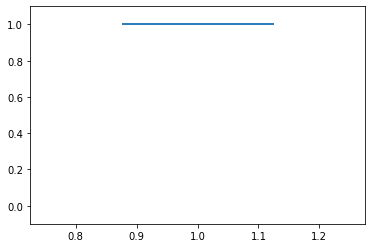

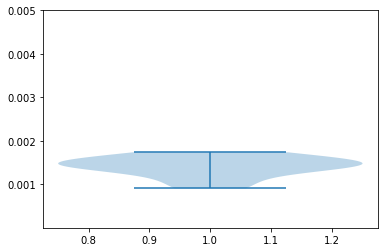

In [91]:
def plot_avg_reward(episode_stats):
    values = [sum(stats["reward"]) for stats in episode_stats]
    fig, ax = pyplot.subplots()
    ax.violinplot(values)
    ax.set(
        ylim=(-0.1, 1.1)
    )
    return fig, ax

def plot_avg_action(episode_stats):
    values = [stats["info"][0]["action"][0] for stats in episode_stats]
    fig, ax = pyplot.subplots()
    ax.violinplot(values)
    ax.set(
        ylim=(5e-6, 5e-3)
    )
    return fig, ax
    
fig, ax = plot_avg_reward(episode_stats)
fig, ax = plot_avg_action(episode_stats)
pyplot.show()